# Use NREL NSRDB Physical Solar Model version 3 in R

## Getting the PSM3 data (for multiple points)

#### Install and load neccessary R packages

Similar to the previous section, more packages are required here.

In [1]:
#isntall packages
#install.packages(c("httr", "maps", "maptools", "ggplot2"))

#load packages
libs <- c("httr", "maps", "maptools", "ggplot2")
invisible(lapply(libs, library, character.only = TRUE))

Loading required package: sp
Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()


#### Define the points to be downloaded

The entire dataset is over 40TB, so downloading the entire dataset is not sensible. However, there are several ways that you can meaningfully select the grid points of interest. Since there is a [2000 request/day limit](https://developer.nrel.gov/docs/solar/nsrdb/guide/), you may want to work on your spatial sampling design before you start downloading. Some example designs:
- build the lattice around a ground-based station
    - regular grid
    - irregular grid
- sample within a `SpatialPolygon`
    - regular grid
    - irregular grid
In the following example, we sample a $0.2^\circ\times 0.2^\circ$ regular grid, and an irregular grid of the same size, in California. **Note**: given the spatial resolution of the PSM3 data, the finest grid you can use is $0.04^\circ\times 0.04^\circ$.

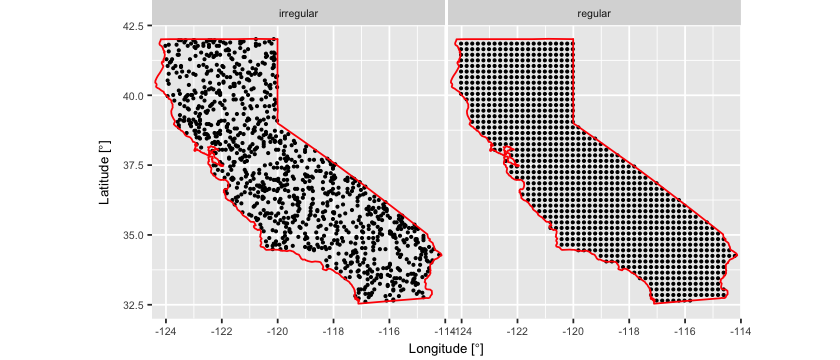

In [2]:
#California map information
California <- maps::map('state', region = 'california', fill = TRUE, plot = FALSE)
boundary <- maptools::map2SpatialPolygons(California, IDs = 'california', proj4string=CRS("+proj=longlat +datum=WGS84"))
bndary <- boundary@polygons[[1]]@Polygons[[1]]@coords
bndary_plot <- data.frame(bndary); names(bndary_plot) <- c("lon", "lat");
#generate the regular grid
res = 0.2
x1 <- seq(-124.02, -114.1, by = res)
y1 <- seq(42.05, 32.40, by = -res)
loc1 <- expand.grid(x1,y1) #regular grid
loc_reg <- loc1[which(point.in.polygon(point.x = loc1[,1], point.y = loc1[,2], pol.x = bndary[,1], pol.y = bndary[,2])==1),]
#generate all points following original, i.e., most granular, grid
x2 <- seq(-124.02, -114.1, by = 0.04)
y2 <- seq(42.05, 32.40, by = -0.04)
loc2 <- expand.grid(x2,y2) #PSM3 grid
loc_irreg <- loc2[which(point.in.polygon(point.x = loc2[,1], point.y = loc2[,2], pol.x = bndary[,1], pol.y = bndary[,2])==1),]
loc_irreg <- loc_irreg[sample(x = 1:nrow(loc_irreg), size = nrow(loc_reg), replace = FALSE),]

#plot
data_plot <- data.frame(lon = append(loc_reg[,1], loc_irreg[,1]), lat = append(loc_reg[,2], loc_irreg[,2]), group = c(rep('regular', nrow(loc_reg)), rep('irregular', nrow(loc_irreg))))
p <- ggplot() + 
     geom_point(data=data_plot,aes(x=lon,y=lat), size = 0.5)+
     geom_polygon(data=bndary_plot,aes(x=lon,y=lat), size = 0.5, color = 'red', fill = NA)+
     facet_wrap(~group) +
     coord_fixed() +
     scale_x_continuous(limits=c(-124.5, -114), expand = c(0, 0)) +
     scale_y_continuous(limits=c(32, 42.5), expand = c(0, 0)) +
     xlab(expression(paste("Longitude [", degree, "]", sep = ""))) +
     ylab(expression(paste("Latitude [", degree, "]", sep = ""))) +
     theme_gray() +
     theme(plot.margin = unit(c(0,0,0,0), "lines"), panel.spacing = unit(0.1, "lines"), text = element_text(size = 8), legend.position = "none")  
options(repr.plot.width=7, repr.plot.height=3) #This is only for Jupyter, if you want to output in pdf, using the commented code below
p

#setwd('Your file path')
#ggsave(filename = "lattice.pdf", plot = p, path = getwd(), scale = 1, width = 80, height = 45, unit = "mm", dpi = 300)

#### Use API to download csv files

After the points are defined, we again use the API to download, but this time with a loop.

In [3]:
################################################################################
# API request parameters, except for longitude and latitude
# Declare all variables as strings. Spaces must be replaced with '+', i.e., change 'John Smith' to 'John+Smith'.
################################################################################
# You must request an NSRDB api key from the link above
api_key <- 'FVltdchrxzBCHiSNF6M7R4ua6BFe4j81fbPp8dDP'
# Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
attributes <- 'ghi,dhi,dni,clearsky_dhi,clearsky_dni,clearsky_ghi,solar_zenith_angle'
# Choose year of data
year = '2016'
# Set leap year to true or false. True will return leap day data if present, false will not.
leap_year = 'true'
# Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 30 & 60.
interval = '30'
# Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will use the local time zone of the data.
# NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'. SAM requires the data to be in the
# local time zone.
utc = 'false'
# Your full name, use '+' instead of spaces.
your_name = 'John+Smith'
# Your reason for using the NSRDB.
reason_for_use = 'research'
# Your affiliation
your_affiliation = 'Your+Institute'
# Your email address
your_email = 'your.email@gmail.com'
# Please join our mailing list so we can keep you up-to-date on new developments.
mailing_list = 'false'
################################################################################
#downloading takes some time, so in this example, three points are used as an exmaple
loc_irreg <- loc_irreg[sample(1:nrow(loc_irreg), 3, replace = FALSE),]
names(loc_irreg) <- c("lon", "lat")

for(i in 1:nrow(loc_irreg))
{
  lat <- loc_irreg$lat[i]
  lon <- loc_irreg$lon[i]
  
  # Declare url string
  URL <- paste0('http://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT(', lon, '+', lat, ')&names=', year, '&leap_day=', leap_year, '&interval=', interval, '&utc=', utc, '&full_name=', your_name, '&email=', your_email, '&affiliation=', your_affiliation, '&mailing_list=', mailing_list, '&reason=', reason_for_use, '&api_key=', api_key, '&attributes=', attributes)
  # name the output file
  output_file <- paste0(lat, "_", lon, "_", year, ".csv")
  # API request and saving
  GET(url = URL, write_disk(output_file))
  print(i)
}

[1] 1
[1] 2
[1] 3


Now, all the requested files have been downloaded. 